# Exploratory data analysis

In [138]:
pip install rdkit pandas seaborn scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 13.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [87]:
import pandas as pd

In [88]:
df = pd.read_csv('bioactivity_preprocecssed_data.csv')
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate


## Calculate Lipinski descriptors

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:
- Molecular weight < 500 Dalton
- Octanol-water partition coefficient (LogP) < 5
- Hydrogen bond donors < 5
- Hydrogen bond acceptors < 10


In [89]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### Calculate descriptors

In [90]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [91]:
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski.head()

,MW,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0
3,293.347,3.63080,0.0,3.0
4,338.344,3.53900,0.0,5.0


In [92]:
df_combined = pd.concat([df, df_lipinski], axis=1)
df_combined.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,338.344,3.53900,0.0,5.0


## Convert IC50 to pIC50
To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
- Take the IC50 values from the standard_value column and convert it from nM to M by multiplying the value by 10^-9
- Take the molar value and apply -log10
- Delete the standard_value column and create a new pIC50 column 

In [125]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9)
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)
        
    return x

In [126]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1)

    return x

In [127]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,7200.00
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,9400.00
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,13500.00
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,13110.00
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,2000.00
...,...,...,...,...,...,...,...,...
240,CHEMBL4590273,Cc1cccc2nc(CSC(=S)NCc3cccnc3)cn12,active,328.466,3.34562,1.0,5.0,380.19
241,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],active,222.379,-1.99300,1.0,3.0,165.00
242,CHEMBL2365410,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1C...,active,485.559,0.54470,5.0,7.0,161.00
243,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],NaN,222.379,-1.99300,1.0,3.0,165.96


In [128]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,5.698970
...,...,...,...,...,...,...,...,...
240,CHEMBL4590273,Cc1cccc2nc(CSC(=S)NCc3cccnc3)cn12,active,328.466,3.34562,1.0,5.0,6.419999
241,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],active,222.379,-1.99300,1.0,3.0,6.782516
242,CHEMBL2365410,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1C...,active,485.559,0.54470,5.0,7.0,6.793174
243,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],NaN,222.379,-1.99300,1.0,3.0,6.779997


In [129]:
df_final.pIC50.describe()

count    245.000000
mean       4.894585
std        0.911338
min        2.698970
25%        4.327902
50%        4.823909
75%        5.301030
max        7.301030
Name: pIC50, dtype: float64

In [130]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class

df_2class.pIC50.describe()

count    199.000000
mean       4.798385
std        0.961623
min        2.698970
25%        4.301030
50%        4.698970
75%        4.980928
max        7.301030
Name: pIC50, dtype: float64

## Exploratory Data Analysis (Chemical space analysis) via Lipinski descriptors

In [131]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

palette = ['#D20103', '#7DDA58']

### Frequency plot of the 2 bioactivity classes

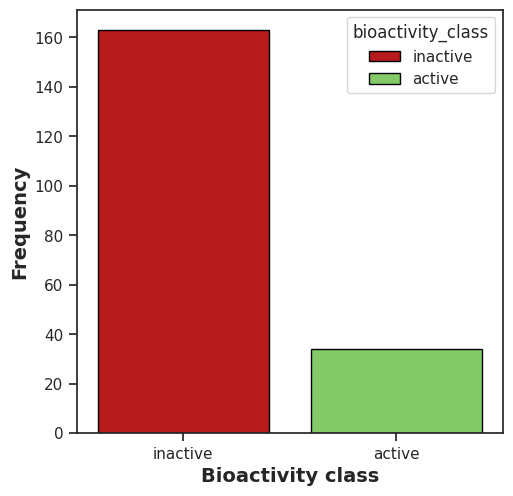

In [132]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black', hue='bioactivity_class', palette=palette)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### Scatter plot of MW versus LogP
It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP

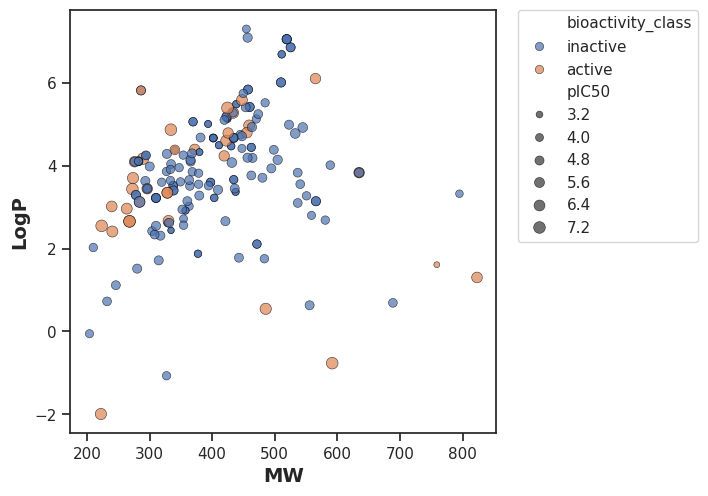

In [133]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_logP.pdf')

### pIC50 value

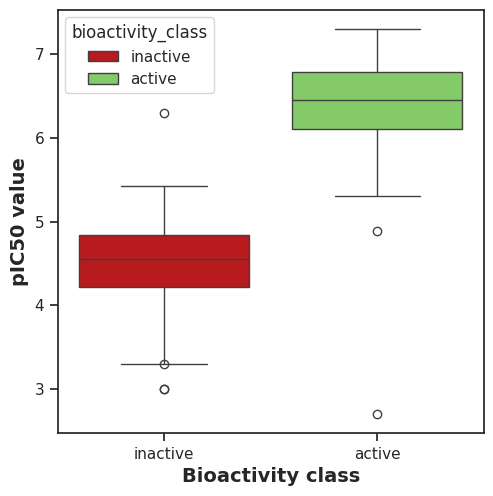

In [134]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='pIC50', data=df_2class, hue='bioactivity_class', palette=palette)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

### Statistical analysis | Mann-Whitney U Test
Test the statistival significance of the difference between the 2 bioactivity classes

In [135]:
def mannwhitney(descriptor, verbose=False):
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu

    # seed the random number generator
    seed(1)

    # actives and inactives
    selection = [descriptor, 'bioactivity_class']
    df = df_2class[selection]
    active = df[df.bioactivity_class == 'active']
    active = active[descriptor]

    selection = [descriptor, 'bioactivity_class']
    df = df_2class[selection]
    inactive = df[df.bioactivity_class == 'inactive']
    inactive = inactive[descriptor]

    # compare samples
    stat, p = mannwhitneyu(active, inactive)

    # interpret
    alpha = 0.05
    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
    else:
        interpretation = 'Different distribution (reject H0)'
    
    results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv(filename)
    
    return results
    

### MW

In [139]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,5332.5,2.425019e-17,0.05,Different distribution (reject H0)


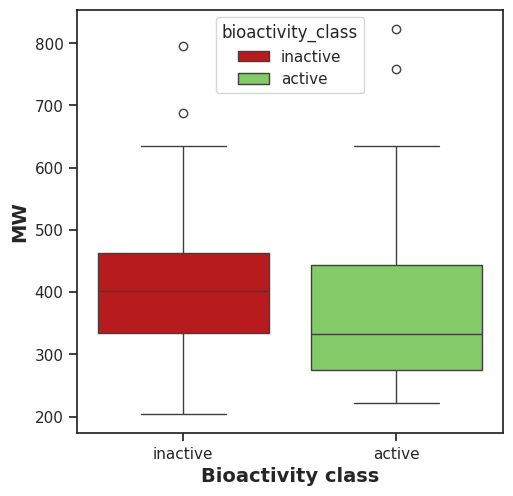

In [145]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class, hue='bioactivity_class', palette=palette)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

### LogP

In [142]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,2426.0,0.254586,0.05,Same distribution (fail to reject H0)


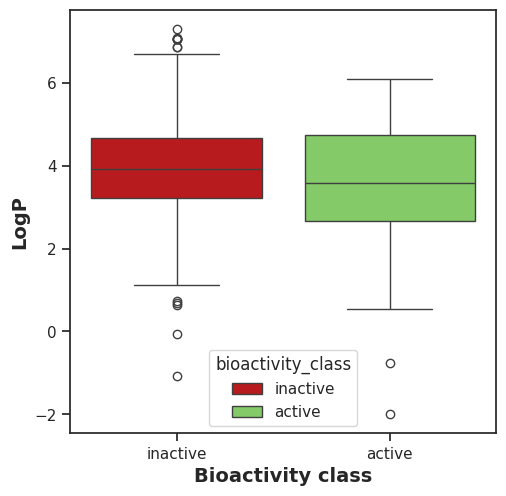

In [146]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class, hue='bioactivity_class', palette=palette)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

### NumHDonors

In [143]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1840.5,0.001321,0.05,Different distribution (reject H0)


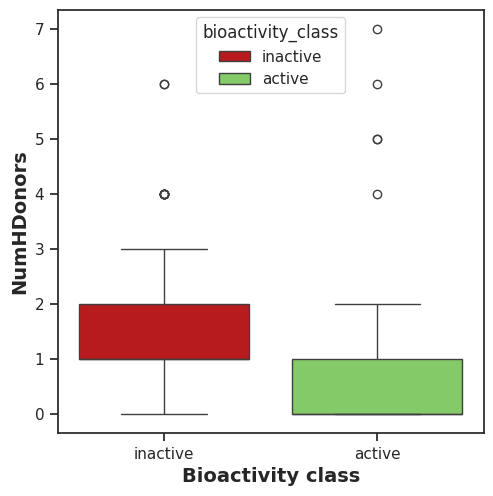

In [149]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class, hue='bioactivity_class', palette=palette)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

### NumHAcceptors

In [150]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,2017.5,0.011724,0.05,Different distribution (reject H0)


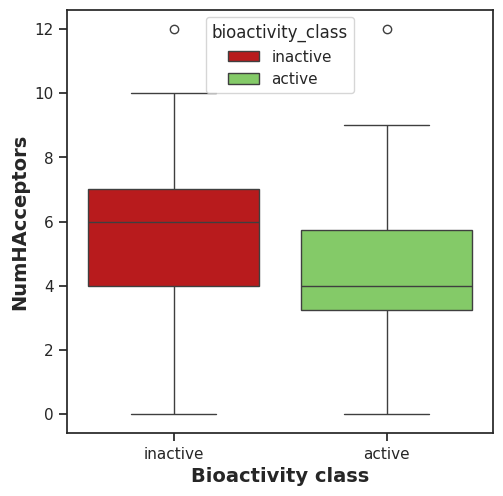

In [151]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class, hue='bioactivity_class', palette=palette)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

## Interpretations of Statistical Results

### Box Plots
#### pIC50 values
Taking a look at pIC50 values, the **actives** and **inactives** displayed statiscally significant differnce, which is to be expected since threshold values (IC50 < 1000 nM = Actives, while IC50 > 10000 nM = Inactives, corresponding to pIC50 > 6 = Actives and pIC50 < 5 = Inactives) were used to define actives and inactives

#### Lipinski's descriptors
Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), only LogP exhibited **no difference** between **actives** and **inactives** while the other 3 descriptors (MW, NumHDonors and NumHAcceptors) show **statistically significant difference** between **actives** and **inactives**

## Zip Files

In [153]:
! zip -r results.zip . -i *.csv *.pdf

  adding: bioactivity_data.csv (deflated 91%)
  adding: bioactivity_preprocecssed_data.csv (deflated 82%)
  adding: mannwhitneyu_LogP.csv (deflated 7%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 12%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 10%)
  adding: mannwhitneyu_pIC50.csv (deflated 10%)
  adding: plot_bioactivity_class.pdf (deflated 36%)
  adding: plot_ic50.pdf (deflated 37%)
  adding: plot_LogP.pdf (deflated 38%)
  adding: plot_MW.pdf (deflated 37%)
  adding: plot_MW_vs_logP.pdf (deflated 11%)
  adding: plot_NumHAcceptors.pdf (deflated 35%)
  adding: plot_NumHDonors.pdf (deflated 37%)
